# Data Analysis and Mining: First Project

In [29]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt

import statsmodels.api as sm
from scipy.stats import norm
import scipy
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go

# Reading the data
df = pd.read_csv('CSM dataset.csv', sep=';')

# We are working only with the entries that don't have missing values
df.dropna(axis=0, inplace = True)
df.reset_index(drop=True, inplace=True)
df

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,"6,3",8,9130,4000000,45.0,1,0,3280543,4632,425,636,1120000.0
1,22 Jump Street,2014,"7,1",1,192000000,50000000,3306.0,2,2,583289,3465,61,186,12350000.0
2,3 Days to Kill,2014,"6,2",1,30700000,28000000,2872.0,1,0,304861,328,34,47,483000.0
3,300: Rise of an Empire,2014,"6,3",1,106000000,110000000,3470.0,2,0,452917,2429,132,590,568000.0
4,A Haunted House 2,2014,"4,7",8,17300000,3500000,2310.0,2,0,3145573,12163,610,1082,1923800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Me and Earl and the Dying Girl,2015,"8,2",8,6740000,8000000,34.0,1,15,4032265,18398,302,1298,2208.0
183,The Vatican Tapes,2015,"4,5",15,1710000,8495000,420.0,1,-2,1364537,3824,689,772,3841.0
184,Maggie,2015,"5,6",3,131000,4500000,79.0,1,10,5085068,14359,600,2468,3744000.0
185,Americons,2015,"7,3",3,129000,4000000,14.0,1,0,63724,115,28,14,129000.0


In [9]:
print("After considering only movies which have all of the desired data, we are left with " + str(df.shape[0]) +
      " rows (entries) and " + str(df.shape[1]) + " columns (features)")

After considering only movies which have all of the desired data, we are left with 187 rows (entries) and 14 columns (features)


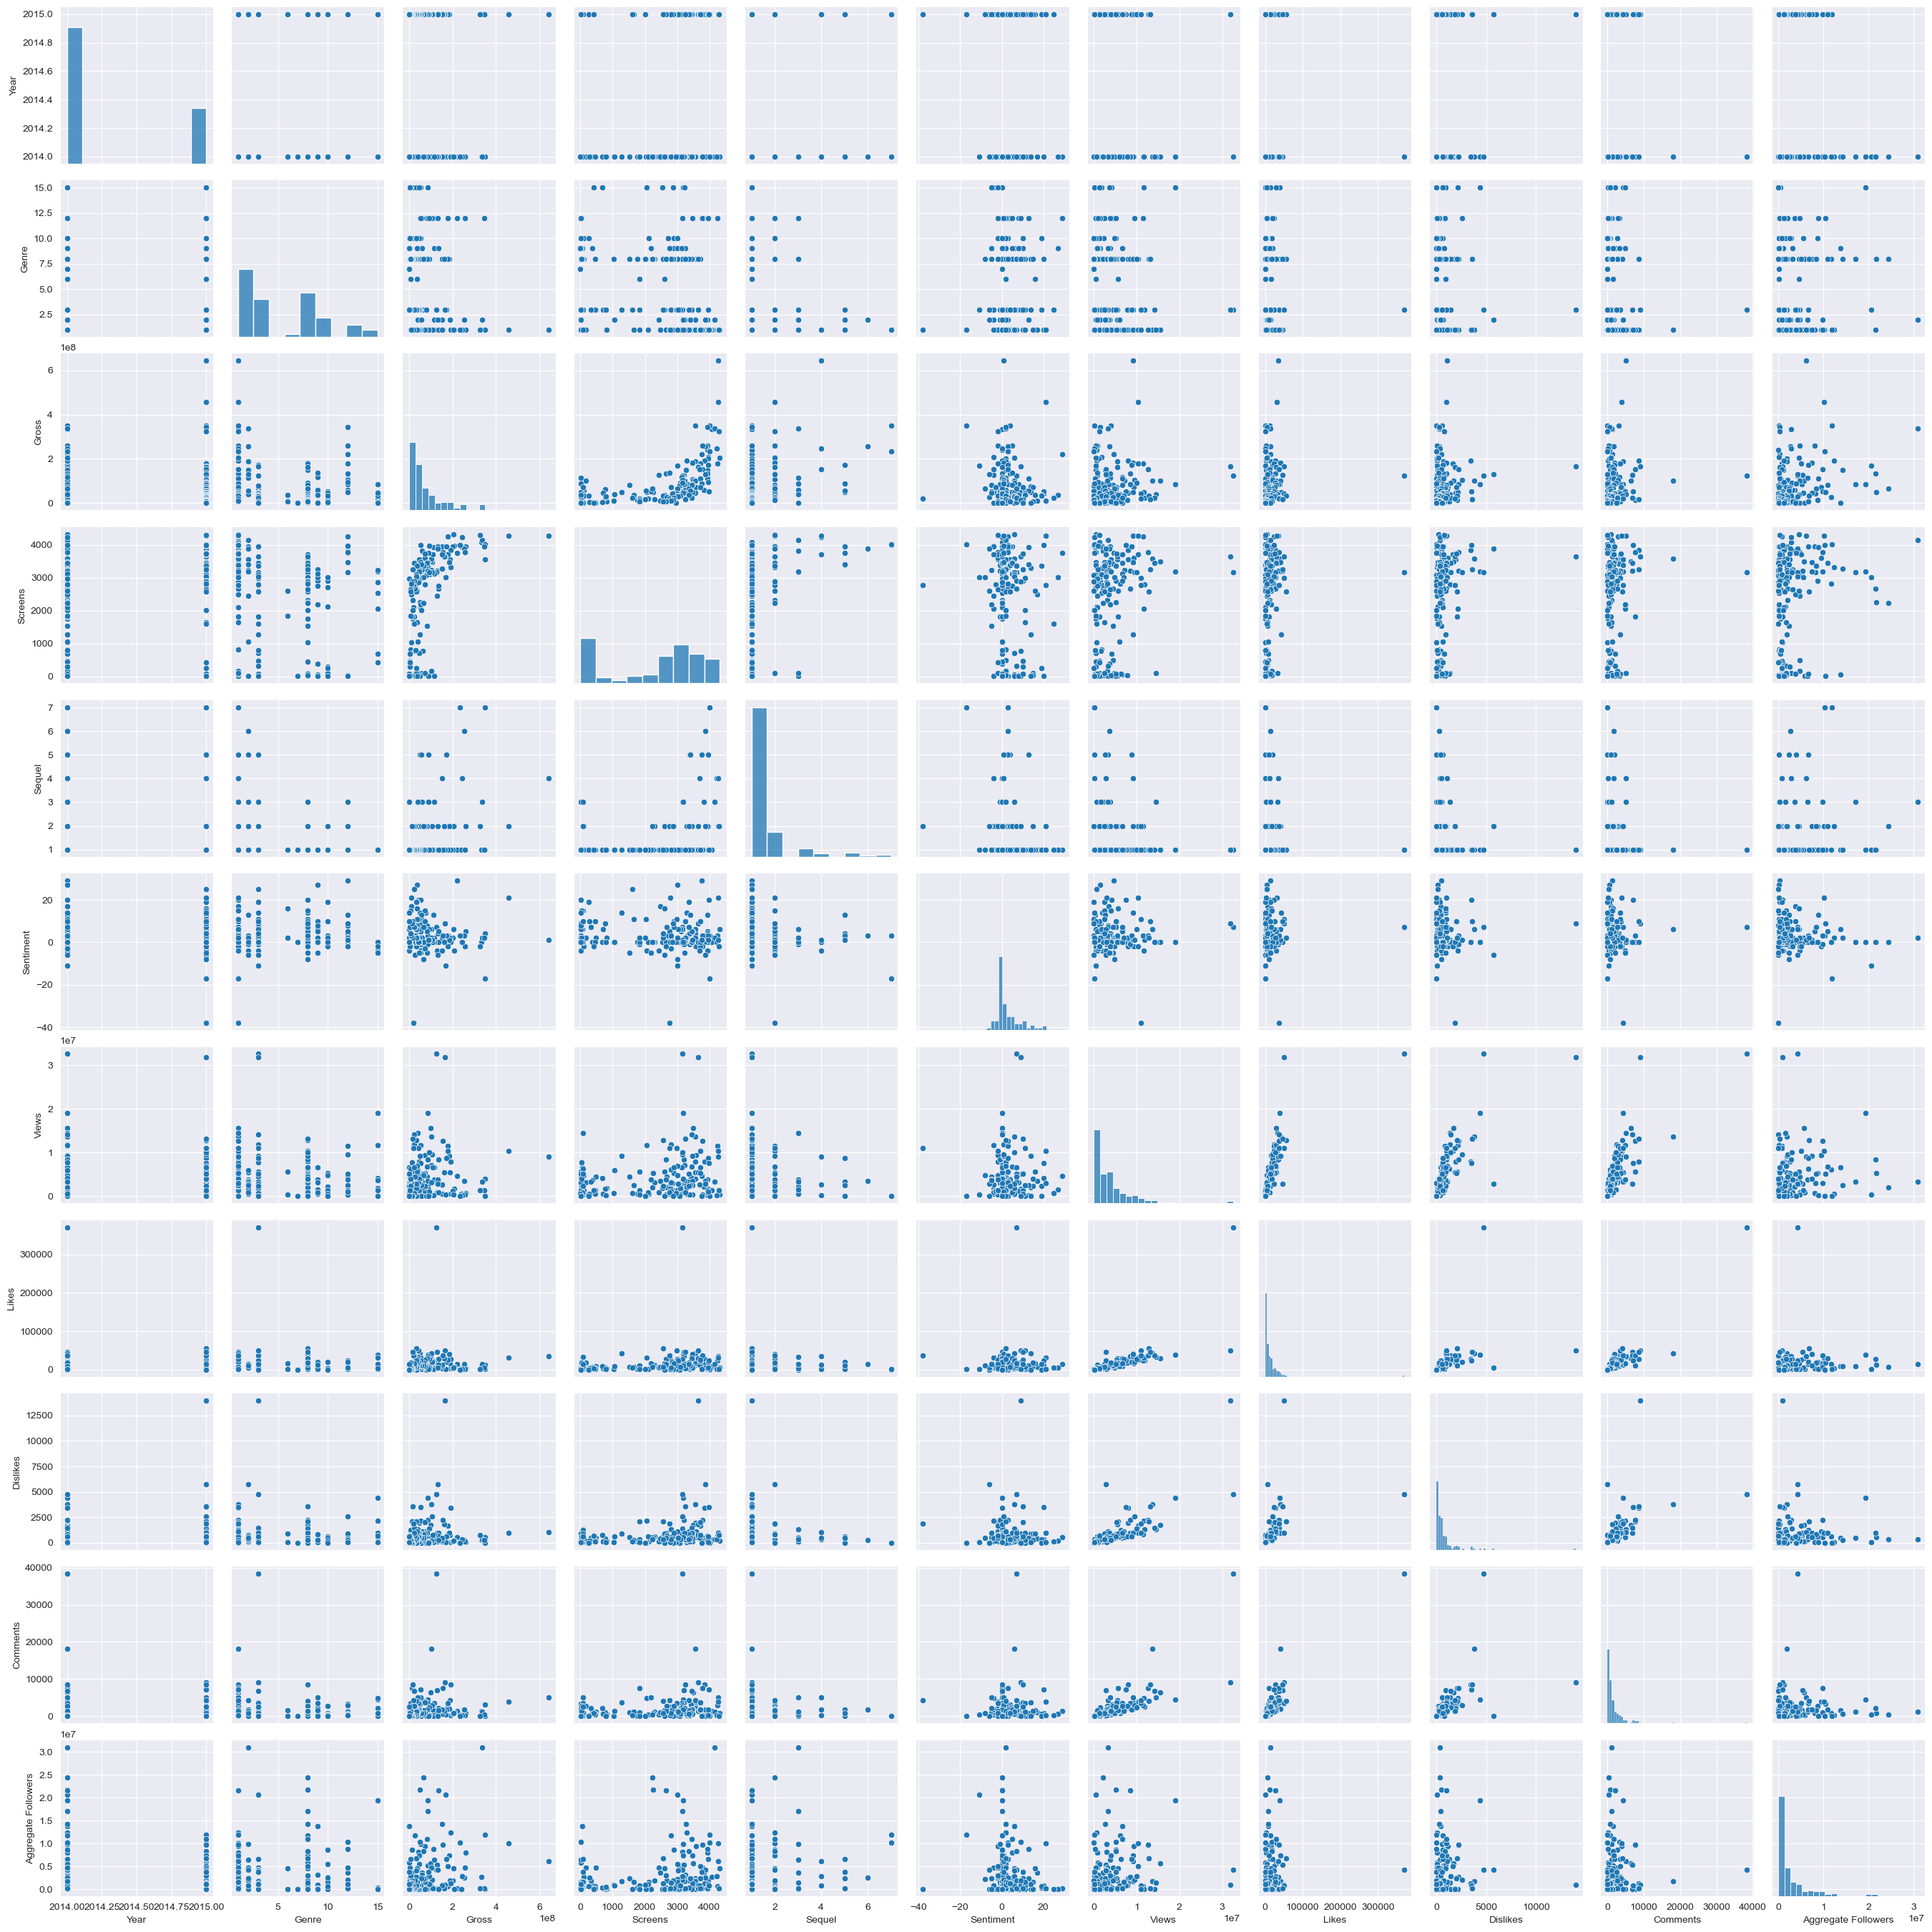

In [10]:
sns.pairplot(df)

#### Propositions of features for building a linear regression model: Views ~ Likes or Comments ~ Views

<Axes: xlabel='Views', ylabel='Comments'>

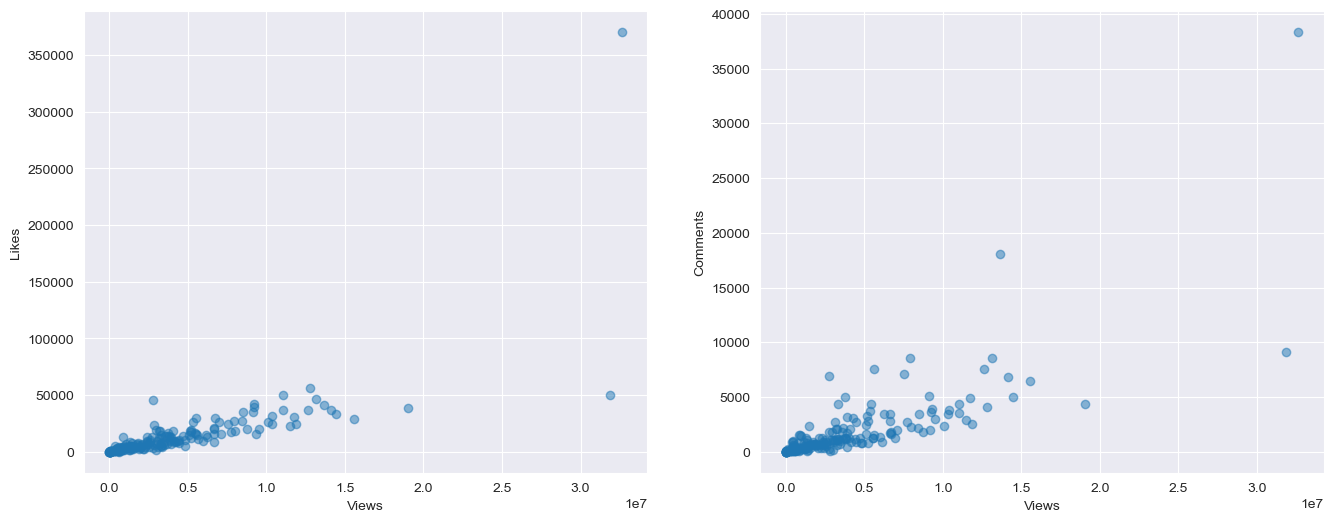

In [11]:
sth, axes = plt.subplots(ncols=2, figsize=(16, 6))

sns.regplot(x = df['Views'], y = df['Likes'], fit_reg=False, ax = axes[0], lowess=True, scatter_kws={'alpha':0.5})
sns.regplot(x = df['Views'], y = df['Comments'], fit_reg=False, ax = axes[1], lowess=True, scatter_kws={'alpha':0.5})


The linear relationship between the variables is clearly stronger in the first scatterplot. There is only one big outlier (near the value 30M Views). Possibly another point with similar number of views can be regarder as an outlier but it isn't that clear without drawing the regression line. We can also see that the smaller our independent variable gets, the linear relationship seems to be stronger in both cases.

From now on we are going to perform the linear regression analysis on features 'Likes' and 'Views' (first scatterplot).

Estimated coefficients of the regression line: 
Slope:  0.004407 
Intercept:  -4331.0


C:\Users\Robert\AppData\Local\Temp\ipykernel_10152\337464959.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = np.linalg.lstsq(x_aug, y)[0]


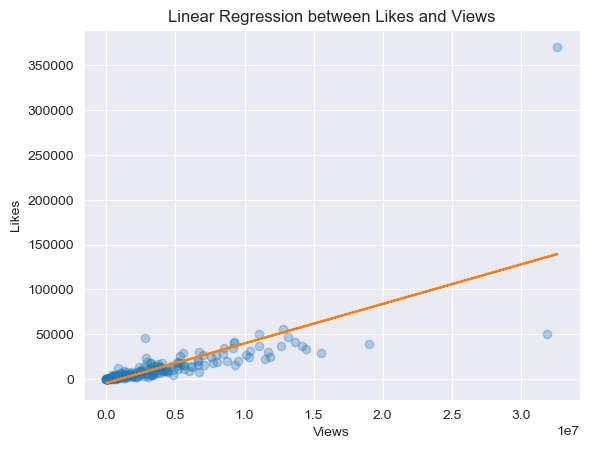

In [12]:
x = df.loc[:, 'Views'].values.reshape(-1,1)
y = df.loc[:, 'Likes'].values.reshape(-1,1)

# Apart from the slope, we are including the intercept in out estimation
x_aug = np.c_[np.ones(len(x)), x]

# We are using the Least Squares method to estimate linear coefficients
beta = np.linalg.lstsq(x_aug, y)[0]
print("Estimated coefficients of the regression line:",
      "\nSlope: ", float('%.*g'% (4, beta[1][0])),
      "\nIntercept: ", float('%.*g'% (4, beta[0][0])))

predictions = np.matmul(x_aug, beta)

ax = sns.regplot(x=x, y=y, fit_reg=False, lowess=True, scatter_kws={'alpha':0.3})
ax.set(xlabel = "Views", ylabel = "Likes",
      title = "Linear Regression between Likes and Views")
plt.plot(x, predictions)


In our case the intercept has no interpretation since there isn't a movie with 0 Views (which we are going to check later). However, the slope of the regression line has its meaing; for each increase of 1000 Views, we estimate the number of Likes to go up approximately by 4.4.

In [13]:
print("Coefficient of Determinantion: ", round(r2_score(y_true=y, y_pred=predictions),2))

Coefficient of Determinantion:  0.52


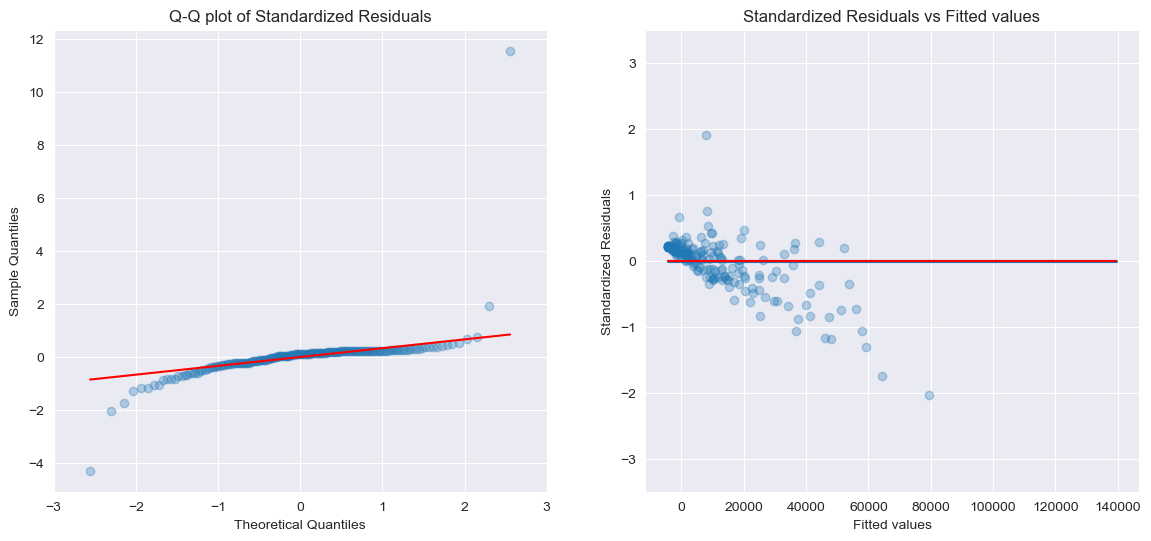

In [42]:
# Q-Q Plot and Standardized residuals plot
residuals = y - predictions
n_min_deg = len(y) - (1+x.shape[1])

residuals_std = np.sqrt( (1/n_min_deg) * np.sum(residuals**2) )

leverage = ( (1/len(x))  +  ((x - np.mean(x)**2) / np.sum((x - np.mean(x))**2)) )
standardized_residuals = residuals / (residuals_std * np.sqrt( 1 - leverage))


fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals), scipy.stats.norm,
          line='q', ax=axs[0], alpha=0.3)
#sm.qqplot(np.squeeze(measurements), scipy.stats.norm,
#          line='45', ax=axs[0])
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)

sns.regplot(x=predictions[:,0], 
            y=standardized_residuals, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions[:,0]), max(predictions[:,0])], [0, 0], 'r-')
axs[1].set_ylim(-3.5,3.5)
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

The Q-Q plot indicates that the error terms probably follow a left-skewed normal distribution but we can't see the pattern there clearly due to the scale of the y-axis affected by the outliers. Let's make the plots again, this time igorning the big outliers on the Q-Q plot in order to get a clearer picture for further analysis.

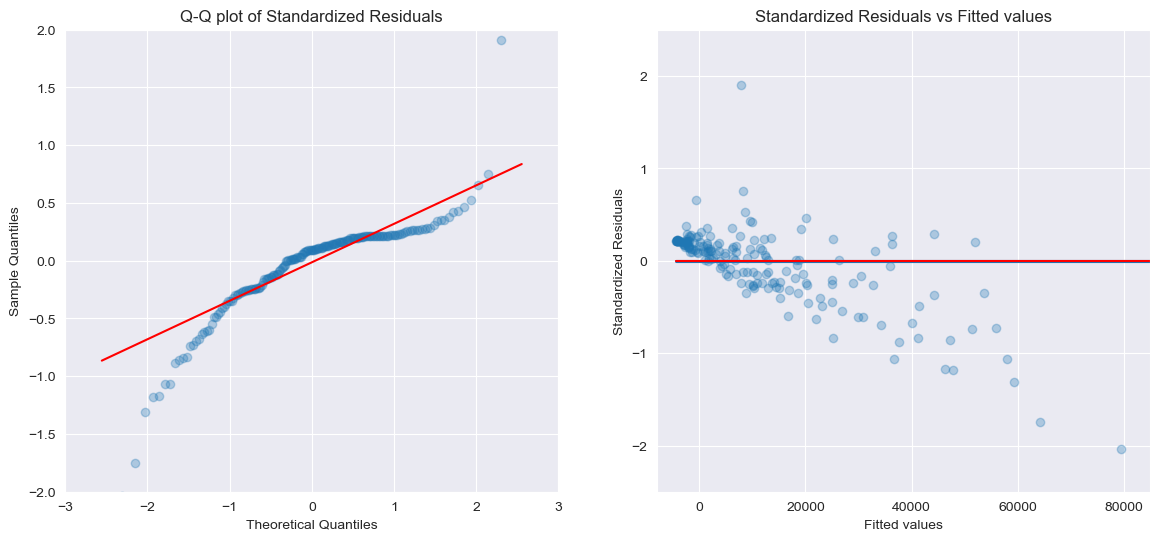

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals), scipy.stats.norm,
          line='q', ax=axs[0], alpha = 0.3)
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)
#---
axs[0].set_ylim(-2,2)
#---

sns.regplot(x=predictions[:,0], 
            y=standardized_residuals, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions[:,0]), max(predictions[:,0])], [0, 0], 'r-')
#---
axs[1].set_xlim(-8000,85000)
axs[1].set_ylim(-2.5,2.5)
#---
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

The 'Q-Q plot' depicts some deviation from linearity which indicates that the residuals don't follow exactly a normal distribution. However, we can claim that their distribution is similar to normal but with some left-skewness and a shorter right tail.

Another important thing to notice is the accumulation of the points around the median/mean. The residuals may well accumulate more densely around the mean than a normal distribution but we can't conclude it from this Q-Q plot. 

<br/>

Further insights can be provided by looking at the second plot; it should make us suspect the residuals violate the following regression assumptions:
- *Zero Mean Assumption* (Because for very small x-values the residuals are positive and for the larger the x-value, the residuals tend to take more negative values. If this assumption was satisfied, the error terms should oscilate around 0, regardless of x-value)
- *Constant Variance Assumption* (Residual variance increases as the x-values increase, contradicting the assumption that the variance of the error terms is constant)
- *Independence Assumption* (It is violated specifically for the small values of x-axis; we can see there is an aggregation of points with positive value that are close to each other. Therefore, being given a residual, we can predict the vaules of the neighbouring ones. *Independence Assumption* means we shouldn't be able to do that as we assume these values to be independent from each other)

It is also helpful to see the normalized histogram of the standardized_residuals:

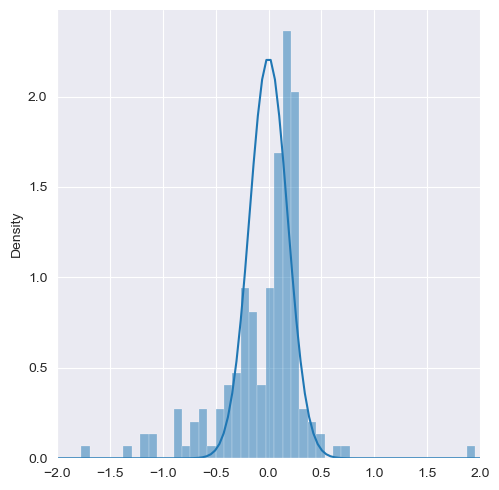

In [119]:
sns.displot(standardized_residuals, bins = 200, stat = 'density', common_norm = True, legend = False)
plt.xlim(-2,2)

lsp = np.linspace(-2, 2, 100)
n1 = norm.pdf(lsp, loc=0, scale=0.18)
plt.plot(lsp, n1)
plt.show()

On this plot we can see the left-skewness of the residuals more clearly.

#### Applying the log-transformation to the data

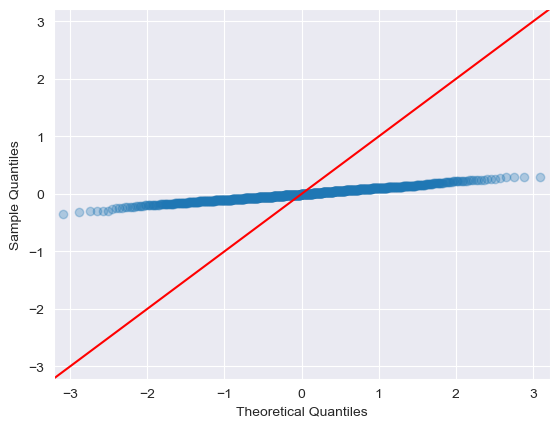

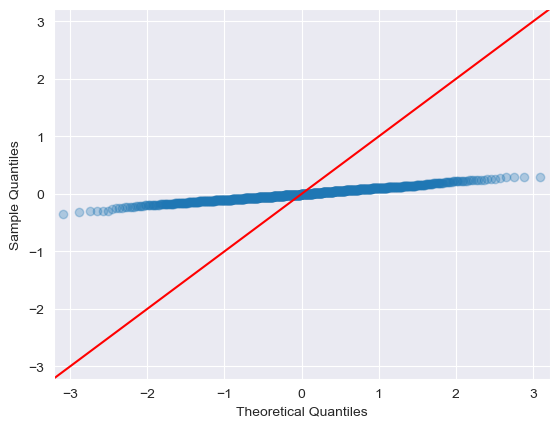

In [80]:
# n1 = norm.pdf(lsp, 0, 1)
# dt = np.random.normal(loc=0, scale=0.1, size=1000)

# sm.qqplot(np.squeeze(dt), scipy.stats.norm,
#           line='45', alpha = 0.3)
#

In [ ]:
#???
import ipywidgets

In [ ]:
x_trans = np.log(x)
y_trans = np.log(y)

In [ ]:
# Linear regression using transformed features

x_trans_aug = np.c_[np.ones(len(x_trans)), x_trans]

# We are using the Least Squares method to estimate linear coefficients
beta_trans = np.linalg.lstsq(x_trans_aug, y_trans)[0]
print("Estimated coefficients of the regression line:",
      "\nSlope: ", float('%.*g'% (4, beta_trans[1][0])),
      "\nIntercept: ", float('%.*g'% (4, beta_trans[0][0])))

predictions_trans = np.matmul(x_trans_aug, beta_trans)

ax = sns.regplot(x=x_trans, y=y_trans, fit_reg=False, lowess=True, scatter_kws={'alpha':0.3})
ax.set(xlabel = "ln(Views)", ylabel = "ln(Likes)",
      title = "Linear Regression between logarithms of Likes and Views")
plt.plot(x_trans, predictions_trans)

In [ ]:
print("Coefficient of Determinantion: ", round(r2_score(y_true=y_trans, y_pred=predictions_trans),2))

We can clearly see that the Linear Regression fits the transformed features much better than the original ones.

In [ ]:
# Q-Q Plot and Standardized residuals plot
residuals = y_trans - predictions_trans
n_min_deg_ = len(y_trans) - (1+x_trans.shape[1])

residuals_std = np.sqrt( (1/n_min_deg) * np.sum(residuals**2) )

leverage = ( (1/len(x_trans))  +  ((x_trans - np.mean(x_trans)**2) / np.sum((x_trans - np.mean(x_trans))**2)) )
standardized_residuals = residuals / (residuals_std * np.sqrt( 1 - leverage))

sd_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

print(standardized_residuals.shape)
fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals), scipy.stats.norm,
          line='45', ax=axs[0])
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)

sns.regplot(x=predictions_trans[:,0], 
            y=standardized_residuals, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions_trans[:,0]), max(predictions_trans[:,0])], [0, 0], 'r-')
axs[1].set_ylim(-3.5,3.5)
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

In [ ]:
sns.displot(residuals)

In [19]:
measurements = np.random.normal(loc = 0, scale = 1, size=100)


In [ ]:
import pylab
scipy.stats.probplot(np.squeeze(residuals), dist="norm", plot=pylab)

Principal components analysis

In [45]:
#importing necessary libraries
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

We are choosing Ratings, Gross, Budget, Views, Likes and Dislikes for PCA. 

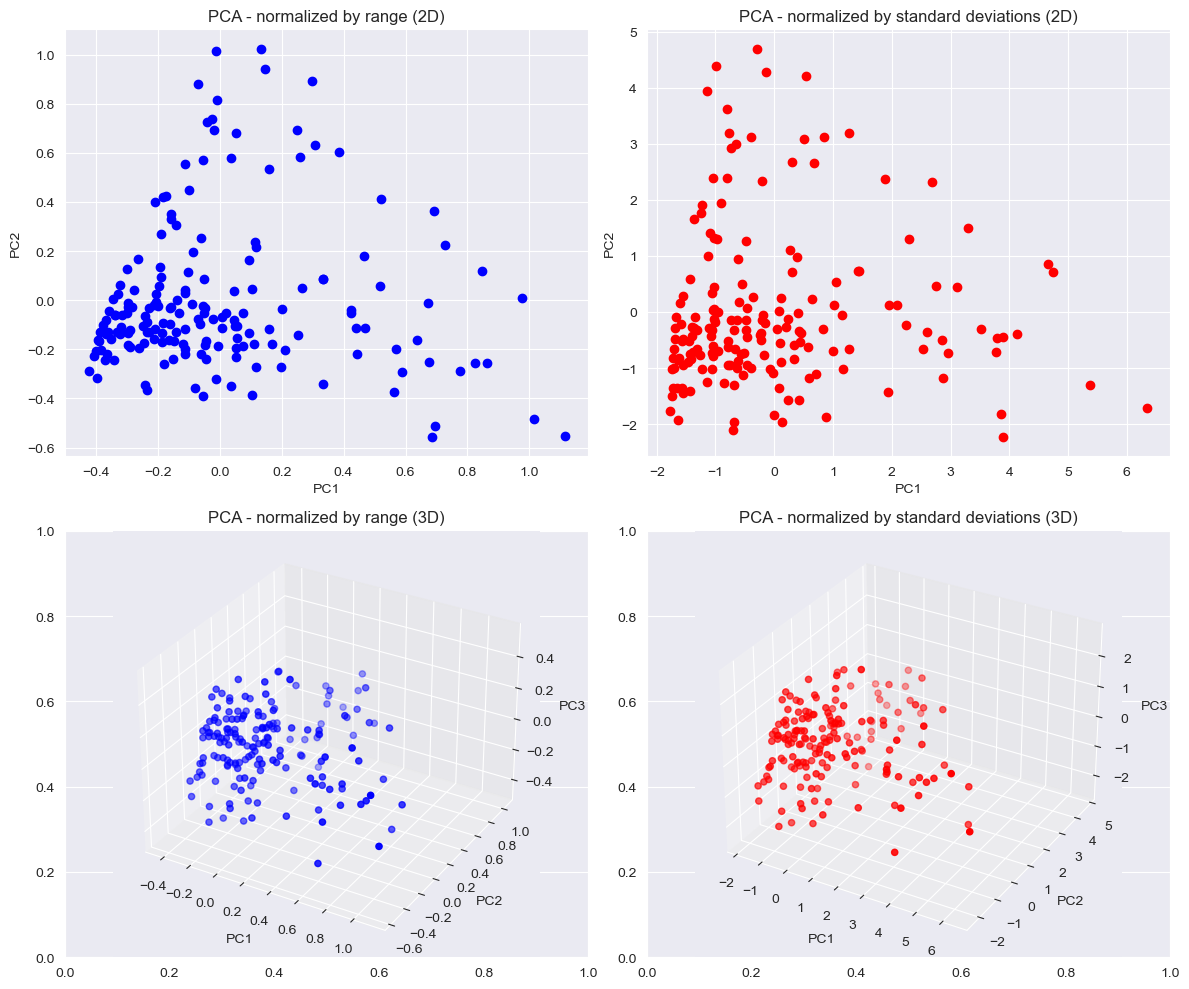

In [46]:

df = pd.read_csv('CSM dataset.csv', sep=';')

df['Ratings'] = df['Ratings'].str.replace(',', '.').astype(float)
df['Budget'] = df['Budget'].str.replace(',', '.').astype(float)
selected_features = ['Ratings', 'Gross', 'Budget', 'Views', 'Likes', 'Dislikes']
X = df[selected_features]

# Remove outliers
clf = IsolationForest(contamination=0.05)  # Determine the level of contamination ???
outliers = clf.fit_predict(X)
X = X[outliers == 1]

# normalization by range
scaler_range = MinMaxScaler()
X_range_normalized = scaler_range.fit_transform(X)

# normalization by standard deviations
scaler_std = StandardScaler()
X_std_normalized = scaler_std.fit_transform(X)

# PCA
pca = PCA(n_components=3)
X_pca_range = pca.fit_transform(X_range_normalized)
X_pca_std = pca.fit_transform(X_std_normalized)

# Data visualization in 2D and 3D
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot for data normalized by range (2D)
axes[0, 0].scatter(X_pca_range[:, 0], X_pca_range[:, 1], c='blue', marker='o')
axes[0, 0].set_title('PCA - normalized by range (2D)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

# Plot for data normalized by standard deviations (2D)
axes[0, 1].scatter(X_pca_std[:, 0], X_pca_std[:, 1], c='red', marker='o')
axes[0, 1].set_title('PCA - normalized by standard deviations (2D)')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')

# Plot for data normalized by range (3D)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(X_pca_range[:, 0], X_pca_range[:, 1], X_pca_range[:, 2], c='blue', marker='o')
ax.set_title('PCA - normalized by range (3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# graph for data normalized by standard deviations (3D)
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(X_pca_std[:, 0], X_pca_std[:, 1], X_pca_std[:, 2], c='red', marker='o')
ax.set_title('PCA - normalized by standard deviations (3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()


(don't use the class attribute in clustering, all the rest features yes)